In [1]:
import sys
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/Gaze_project")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/Gaze_project")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EyeIK")


import pickle as pkl
import numpy as np
import os
# import jax
from matplotlib import pyplot as plt
import json
from juggling_scene import *

In [2]:
%load_ext autoreload
%autoreload 2

In [54]:
from Geometry_Util import *
def output_motion(hk, ek, micro_saccade, outpath, delay=0.0):
    blend_weight = []
    for i in range(1, len(hk[0])-1):
        velocity = math.sqrt((hk[0][i][1]-hk[0][i-1][1])**2 + (hk[0][i-1][2]-hk[0][i][2])**2)
        blend_weight.append([hk[0][i][0], 1 - min(1, velocity/0.75)])
    for i in range(0, len(ek[0])):
        ek[0][i][0] -= delay
    for i in range(0, len(hk[0])):
        hk[0][i][0] -= delay
    out = {"eye_frames": ek,
            "head_frames": hk,
            "micro_saccade": micro_saccade,
            "other_neck": [],
            "envelope":[], 
            "ambient_neck":[]}
            # "output_times": output_times, 
            # "output_targets": output_targets
    with open(outpath, 'wb') as f:
        pkl.dump(out, f, protocol=2)
    print(outpath)
class InternalModelFromCapture:
    def __init__(self, input_json, gaze_arr = None):
        # input json is generated from the quest pro capture from experimentation/Analyze_trajectory_research_paper.py\
        self.input_json = input_json
        self.gaze_arr = gaze_arr
    def estimate_target_pose(self, index):
        if self.gaze_arr is not None:
            angle = self.gaze_arr[:, index]
        else:
            angle = self.input_json["input_target_angle"][:, index]
        pos = directions_from_rotation_angles(np.array([angle]), 100)[0]
        return pos
    def get_base_pose(self):
        return np.array([0, 0, 100])
    
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    if len(x) == 0:
        return [], []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        # while the dispersion is less than the threshold
        while disp <= dispersion_threshold:
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            disp = dispersion(y[window])

        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window[1:2]], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals

def get_gaze_inputs_naive(times, gaze_traj, dispersion_threshold = 3, duraiton_threshold=0.05):
    gaze_traj = rotation_angles_frome_positions(gaze_traj)
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(times, gaze_traj, dispersion_threshold, duraiton_threshold=duraiton_threshold)
    # gaze_fixations_angles = gaze_fixations[:, 1]
    # gaze_fixation_duration = gaze_fixations[:, 2]
    # time arr
    ts = times
    ts = ts - ts[0]
    input_sequence = []
    for i in range(0, len(gaze_fixations)):
        input_sequence.append([ts[gaze_fixations_intervals[i][0]], gaze_fixations[i, 0], gaze_fixations[i, 1]])
    input_sequence = np.array(input_sequence).T
    return input_sequence

def get_gaze_inputs(eye_traj, head_traj, input_times, input_angles):
    gaze_traj = eye_traj[:, 1:] + head_traj[:, 1:]
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(eye_traj[:, 0], gaze_traj[:, 1:], 3, duraiton_threshold=0.05)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]
    # time arr
    ts = eye_traj[:, 0]
    ts = ts - ts[0]
    input_intervals = []
    for i in range(0, len(input_times)-1):
        input_intervals.append([input_times[i], input_times[i+1]])
    input_intervals.append([input_times[-1], input_times[-1]+100])
    # for each intervals of input
    
    for i in range(0, len(input_intervals)):
        # iterate through each gaze interval and find the first time stamp that is within 5 degrees of the input angle
        gaze_fixations_index_in_interval = []
        for j in range(0, len(gaze_fixations_intervals)):
            # it just have to start within the interval
            if ts[gaze_fixations_intervals[j][0]] >= input_intervals[i][0] and ts[gaze_fixations_intervals[j][0]] <= input_intervals[i][1]:
                gaze_fixations_index_in_interval.append(gaze_fixations_intervals[j])
        interval_to_look = [gaze_fixations_index_in_interval[0][0], gaze_fixations_index_in_interval[-1][1]]
        starting_index = -1
        for j in range(interval_to_look[0], interval_to_look[1]):
            if abs(gaze_traj[j, 1] - input_angles[i]) < 1:
                starting_index = j
                break    
        if starting_index == -1:
            for j in range(interval_to_look[0], interval_to_look[1]):
                if abs(gaze_traj[j, 1] - input_angles[i]) < 5:
                    starting_index = j
                    break
        print(interval_to_look, starting_index)
        # plot the trajectory and the starting point
        # plt.plot(ts[interval_to_look[0]:interval_to_look[1]], gaze_traj[interval_to_look[0]:interval_to_look[1], 1])
        plt.plot(ts[interval_to_look[0]:interval_to_look[1]], head_traj[interval_to_look[0]:interval_to_look[1], 1])
        plt.plot(ts[starting_index], head_traj[starting_index, 1], 'r*')
        plt.show()
        
            

    
    for i in range(0, len(input_intervals)):
        continue
        # find the gaze fixations that are in the interval
        gaze_fixations_index_in_interval = []
        for j in range(0, len(gaze_fixations_intervals)):
            # it just have to start within the interval
            if ts[gaze_fixations_intervals[j][0]] >= input_intervals[i][0] and ts[gaze_fixations_intervals[j][0]] <= input_intervals[i][1]:
                gaze_fixations_index_in_interval.append(j)
        # this is the interval of interest
        interval_of_interest = [gaze_fixations_intervals[gaze_fixations_index_in_interval[0]][0], gaze_fixations_intervals[gaze_fixations_index_in_interval[-1]][1]]
        fixations_angles_in_interval = gaze_fixations[gaze_fixations_index_in_interval, 0]
        # find the first angle within 5 degrees of the input angle in this interval
        index_of_first_angle_within_5_degrees = -1
        for j in range(0, len(fixations_angles_in_interval)):
            if abs(fixations_angles_in_interval[j] - input_angles[i]) < 5:
                index_of_first_angle_within_5_degrees = gaze_fixations_index_in_interval[j]
                break
        if index_of_first_angle_within_5_degrees == -1:
            for j in range(0, len(fixations_angles_in_interval)):
                if abs(fixations_angles_in_interval[j] - input_angles[i]) < 10:
                    index_of_first_angle_within_5_degrees = gaze_fixations_index_in_interval[j]
                    break
        print(input_angles[i])
        # plot the gaze trajectory
        plt.plot(ts[interval_of_interest[0]:interval_of_interest[1]], gaze_traj[interval_of_interest[0]:interval_of_interest[1], 1])
        # plot the gaze fixations from the first point to the point that is within 5 degrees of the input angle till the end of the gaze fixations
        plt.plot(ts[gaze_fixations_intervals[index_of_first_angle_within_5_degrees][0]:gaze_fixations_intervals[index_of_first_angle_within_5_degrees][1]], gaze_traj[gaze_fixations_intervals[index_of_first_angle_within_5_degrees][0]:gaze_fixations_intervals[index_of_first_angle_within_5_degrees][1], 1], 'r')
        plt.show()
        
# okay

In [55]:
JUGGLING_SCENE_DATA_ROOT = "C://Users//evansamaa//Documents//GitHub//EyeIK//Juggling//juggling_scenes"
JUGGLING_PKL_DATA_ROOT = "C://Users//evansamaa//Documents//GitHub//EyeIK//Juggling//juggling_TAP_output"
OUTPUT_ROOT = "C://Users//evansamaa//Documents//GitHub//EyeIK//Juggling//output"
file_name = "alternating_column_output"
file_name = "HD_juggle_tennis_fast_output"

scene_json_filename = os.path.join(JUGGLING_SCENE_DATA_ROOT, file_name + ".json") 
motion_json_file_name = os.path.join(JUGGLING_PKL_DATA_ROOT, file_name + "positions.json")

scene_json = json.load(open(scene_json_filename, "r"))
motion_json = json.load(open(motion_json_file_name, "r"))

(126, 3)
[[  0.           0.06666667   0.13333333   0.2          0.26666667
    0.33333333   0.4          0.46666667   0.53333333   0.6
    0.66666667   0.73333333   0.8          0.86666667   0.93333333
    1.           1.06666667   1.13333333   1.2          1.26666667
    1.33333333   1.4          1.46666667   1.53333333   1.6
    1.66666667   1.73333333   1.8          1.86666667   1.93333333
    2.           2.06666667   2.13333333   2.2          2.26666667
    2.33333333   2.4          2.46666667   2.53333333   2.6
    2.66666667   2.73333333   2.8          2.86666667   2.93333333
    3.           3.06666667   3.13333333   3.2          3.26666667
    3.33333333   3.4          3.46666667   3.53333333   3.6
    3.66666667   3.73333333   3.8          3.86666667   3.93333333
    4.           4.06666667   4.13333333]
 [ -5.79067466 -15.72870161 -20.45726466 -22.01037698  30.22112827
   34.86537171  38.79350705  39.58337898  -6.82516634 -12.23049466
  -19.54582378 -23.87417335 -21.8981790

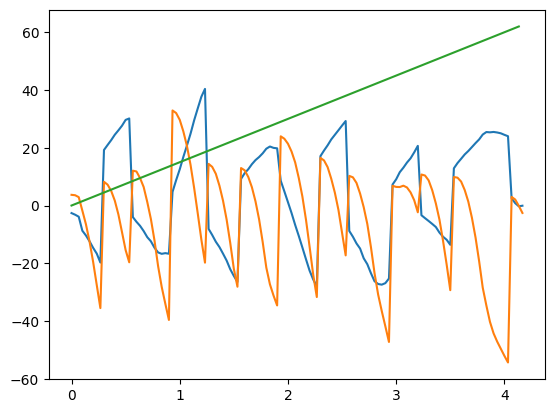

In [ ]:
scene = JugglingScene(scene_json_filename, motion_json_file_name)
traj_temp = scene.get_gaze_trajectory()
traj = np.zeros(traj_temp.shape)
traj[:, 0] = -traj_temp[:, 0]
traj[:, 1] = traj_temp[:, 1]
traj[:, 2] = traj_temp[:, 2]

times = np.arange(0, traj.shape[0])/30
input_sequence = get_gaze_inputs_naive(times, traj, 1, 0.01)
internal_model = InternalModelFromCapture({}, gaze_arr = input_sequence[1:].copy())
gaze_positions = []
print(input_sequence[1:])
for i in range(0, input_sequence.shape[1]):
    gaze_positions.append(input_sequence[1:][:, i])
    
for i in range(0, input_sequence.shape[1]):
    input_sequence[1][i] = int(i)

    
arr_gaze_pos = np.array(gaze_positions)
plt.plot(times, traj[:, 0])
plt.plot(times, traj[:, 1])
# plt.plot(times, traj[:, 2])

plt.plot(input_sequence[0], arr_gaze_pos[:, 0])
# plt.plot(input_sequence[0], arr_gaze_pos[:, 1])
# plt.plot(input_sequence[0], arr_gaze_pos[:, 2])




In [38]:
import networkx as nx
from Proposed_model import *
def dwell_factored_eye_strain_function(dwell_time, angle_j, angle0, angle1):
    # vanilla
    # dwell_time_factor1 = dwell_time
    # dwell_time_factor0 = np.maximum(1.5 - dwell_time, 0)
    # probably better?
    dwell_time_factor1 = np.maximum(0.0001, 1 - np.exp(-0.8*dwell_time)) # this is higher for shorter dwell times)
    dwell_time_factor0 = np.exp(-0.8*dwell_time) # this is higher for longer dwell times
    return dwell_time_factor0 * np.linalg.norm(angle_j - angle1) + dwell_time_factor1 * np.linalg.norm(angle_j - angle0) + 0.4 *np.abs(angle_j)
def head_moving_cost_function(prev, current, dwell_time, laziness=0.6):
    # cost is the distance the the head has to move
    cost = laziness * np.linalg.norm(prev - current)
    if np.linalg.norm(prev - current) <= 4:
        cost = 0
    # but this cost is lowered in the direction of the midline
    # return np.maximum(0.0001, 1.5-np.log(dwell_time + 1)) * cost
    return np.exp(-0.8*dwell_time) * cost
def create_graph(self, laziness=0.5):
    gaze_trajectory_1 = self.input_gaze_pos_as_angles_per_frame
    gaze_trajectory_0 = self.input_gaze_pos_as_angles_per_frame_smoothed
    gaze_positions = self.gaze_pos_as_angles
    gaze_intervals = self.target_gaze_intervals_time
    graphs = []
    for dimension in range(0, 2):
        if dimension == 0:
            range_limit = 60
        else:
            range_limit = 30
        G = nx.DiGraph()
        list_plot = []
        for i in range(0, gaze_positions.shape[0]):
            t_index = int(np.ceil(gaze_intervals[i][0]/self.simulation_dt))
            t_index = min(t_index, gaze_trajectory_0.shape[0]-1)
            target_angle_0 = gaze_trajectory_0[t_index, dimension]
            target_angle_1 = gaze_trajectory_1[t_index, dimension]
            list_plot.append(target_angle_1)
            dwell_time = gaze_intervals[i][1] - gaze_intervals[i][0]
            for j in range(-range_limit, range_limit, 2):
                G.add_node((i, j), value=dwell_factored_eye_strain_function(dwell_time, j, target_angle_0, target_angle_1))
                if i > 0:
                    for j_prev in range(-range_limit, range_limit, 2):
                        G.add_edge((i-1, j_prev), (i, j), weight=head_moving_cost_function(j_prev, j, dwell_time, laziness=laziness))
        G.add_node((gaze_positions.shape[0], int(gaze_positions[-1][dimension])), value=0)
        for j_prev in range(-range_limit, range_limit, 2):
            G.add_edge((gaze_positions.shape[0]-1, j_prev), (gaze_positions.shape[0], int(gaze_positions[-1][dimension])), weight=head_moving_cost_function(j_prev, j, dwell_time))
        graphs.append(G)
    return graphs
def optimize_head_pos(self, laziness=0.54):
    G_0, G_1 = create_graph(self, laziness)
    def combined_weight0(u, v, d):
        return G_0.nodes[v]['value'] + d['weight']
    def combined_weight1(u, v, d):
        return G_1.nodes[v]['value'] + d['weight']
    path_0 = nx.dijkstra_path(G_0, (0, 0), (saccade_generator.gaze_pos_as_angles.shape[0], int(self.gaze_pos_as_angles[-1][0])), combined_weight0)
    path_0 = np.array(path_0)[:, 1:2]
    path_1 = nx.dijkstra_path(G_1, (0, 0), (saccade_generator.gaze_pos_as_angles.shape[0], int(self.gaze_pos_as_angles[-1][1])), combined_weight1)
    path_1 = np.array(path_1)[:, 1:2]
    head_angles = np.concatenate([path_0, path_1], axis=1)
    head_pos = directions_from_rotation_angles(head_angles, 100)
    return head_angles, head_pos 

saccade_generator = Proposed_saccade_generator_with_graph(input_sequence[0], gaze_positions, input_sequence[1], internal_model, reach_target_at_times=False, head_delay=0)

ek_propsed, hk_proposed, micro_saccade_proposed = saccade_generator.compute(optimize_head_pos(saccade_generator)[1])
output_motion(hk_proposed, ek_propsed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "Proposed_graph1.pkl"))
# print("Proposed error", np.sqrt(compare_kf_error_hk(gt_ek, ek_propsed, gt_hk, hk_proposed, name1="GT")))
# compare_kf_plot_hk(gt_ek, ek_propsed, gt_hk, hk_proposed, name2="Proposed", end=plot_ending)

C://Users//evansamaa//Documents//GitHub//EyeIK//Juggling//output\Proposed_graph1.pkl
